In [1]:
import tensorflow as tf
from tensorflow .keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

In [2]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1,10)
            dn = (d +inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1,0]
    return np.array(pairs), np.array(labels)

In [3]:
def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs,y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images =  test_images.astype('float32')
train_images = train_images /255.0
test_images = test_images /255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)


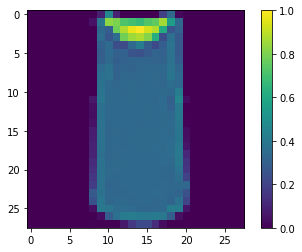

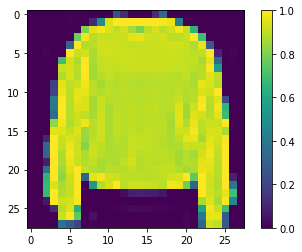

0.0


In [5]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
this_pair = 3
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

In [6]:
def initialize_base_network():
    input = Input(shape=(28,28,), name = "base_input")
    x = Flatten(name = "flatten_input")(input)
    x = Dense(128, activation = 'relu', name = "first_base_dense")(x)
    x = Dropout(0.1, name = "first_dropout")(x)
    x = Dense(128, activation = 'relu', name = "second_base_dense")(x)
    x = Dropout(0.1, name = "second_dropout")(x)
    x = Dense(128, activation = 'relu', name = "third_base_dense")(x)
    return Model(inputs = input, outputs = x)

In [7]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis = 1, keepdims = True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [8]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return(shape1[0], 1)

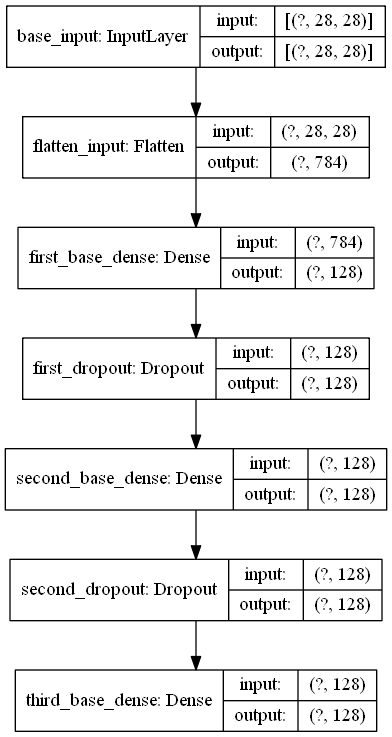

In [9]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

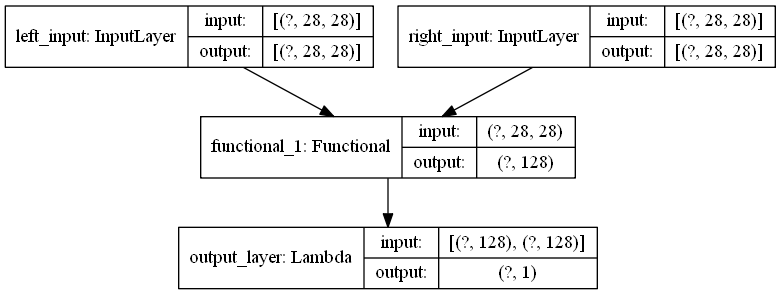

In [10]:
input_a = Input(shape = (28,28,), name = 'left_input')
vect_output_a = base_network(input_a)
input_b = Input(shape = (28,28,), name = 'right_input')
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name = "output_layer", output_shape = eucl_dist_output_shape)([vect_output_a,vect_output_b])
model = Model([input_a, input_b], output)

#plot the model graph

plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'outer-model.png')

In [11]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1-y_true) * margin_square)
    return contrastive_loss

In [12]:
rms = RMSprop()
model.compile(loss = contrastive_loss_with_margin(margin = 1), optimizer = rms)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          
          epochs=20,
          batch_size=128,
          validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

loss = model.evaluate(x = [ts_pairs[:,0],ts_pairs[:,1]], y = ts_y)

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1098 - val_loss: 0.0903
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0789 - val_loss: 0.0767
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0707 - val_loss: 0.0707
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0665 - val_loss: 0.0675
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0638 - val_loss: 0.0676
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0619 - val_loss: 0.0664
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0599 - val_loss: 0.0655
Epoch 8/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0586 - val_loss: 0.0634
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0575 - val_loss: 0.0630
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0567 - val_loss: 0.0636

In [13]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean( pred == y_true)

In [14]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("LOSS = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

LOSS = 0.06157534569501877, Train Accuracy = 0.06028504750791799 Test Accuracy = 0.08448448448448448


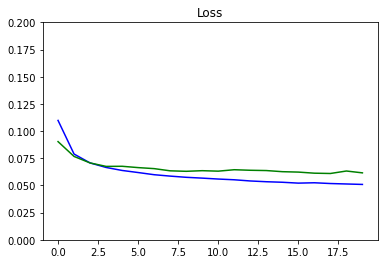

In [15]:
def plot_metrics(metric_name, title, ylim = 5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
    plt.plot(history.history['val_' + metric_name], color = 'green', label = 'val_' + metric_name)
    
plot_metrics(metric_name = 'loss', title = "Loss", ylim = 0.2)

In [16]:
def visualize_image():
    plt.rc('image', cmap = 'gray_r')
    plt.rc('grid', linewidth = 0)
    plt.rc('xtick', top = False, bottom = False, labelsize = 'large')
    plt.rc('ytick', left = False, right = False, labelsize = 'large')
    plt.rc('axes', facecolor = 'F8F8F8', titlesize = 'large', edgecolor = 'white')
    plt.rc('text', color = 'a8151a')
    plt.rc('figure', facecolor = 'F0F0F0')

In [20]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize = (17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left =np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize = (17,3))
    plt.yticks([])
    plt.xticks([28*x + 14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
    plt.grid(None)
    right = np.reshape(right, [n,28,28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

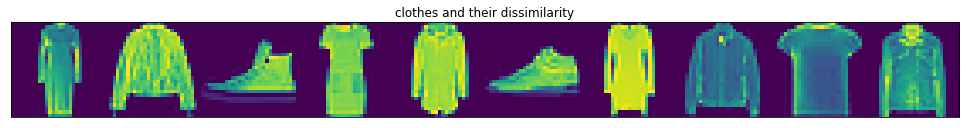

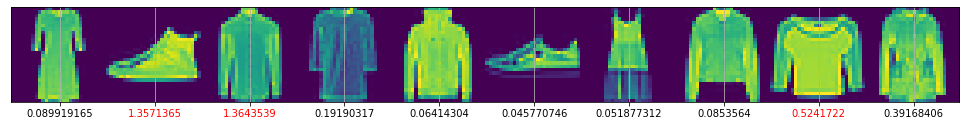

In [21]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)